In [1]:
# import and install library
!pip install yfinance

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import date, timedelta 

In [3]:
# define the time period for the data 
end_date = date.today().strftime("%Y-%m-%d")
start_date = (date.today() - timedelta(days=365)).strftime("%Y-%m-%d")

#list of stock tickers to download
tickers = ['RELIANCE.NS', 'WIPRO.NS', 'TCS.NS', 'INFY.NS', 'HDFCBANK.NS']
data = yf.download(tickers, start=start_date, end=end_date, progress=False)

# Reset index to bring date into the columns
data.reset_index(inplace=True)

# Melt the DataFrame to make it long format where each row is a unique combination of date, tickers, and attributes
# Note: The columns will be a MultiIndex, so we need to flatten it first
data.columns = [' '.join(col).strip() if isinstance(col, tuple) else col for col in data.columns.values]

# Melt the DataFrame to make it long format where each row is a unique combination of date, tickers, and attributes
data_melted = data.melt(id_vars=['Date'], var_name='Attribute_Ticker', value_name='value')

# Split the 'Attribute_Ticker' column into 'Attribute' and 'Ticker'
data_melted[['Attribute', 'Ticker']] = data_melted['Attribute_Ticker'].str.split(' ', expand=True)

# Drop the original 'Attribute_Ticker' column
data_melted.drop(columns=['Attribute_Ticker'], inplace=True)

# pivot the melted DataFrame to have the attributes (open, high, low, etc) as columns
data_pivoted = data_melted.pivot_table(index=['Date', 'Ticker'], columns='Attribute', values='value', aggfunc='first')

# reset index to turn multi-index into columns
stock_data = data_pivoted.reset_index()
print(stock_data.head())

Attribute       Date       Ticker        Close         High          Low  \
0         2024-01-02  HDFCBANK.NS  1676.210571  1679.860799  1665.950651   
1         2024-01-02      INFY.NS  1508.623291  1523.125502  1497.414778   
2         2024-01-02  RELIANCE.NS  1301.432983  1303.077427  1282.148458   
3         2024-01-02       TCS.NS  3729.458252  3756.962067  3713.734876   
4         2024-01-02     WIPRO.NS   233.601486   237.982753   231.161902   

Attribute         Open      Volume  
0          1675.914685  14621046.0  
1          1520.028396   5396313.0  
2          1288.128164   7448800.0  
3          3756.962067   1344068.0  
4           237.982753  14282514.0  


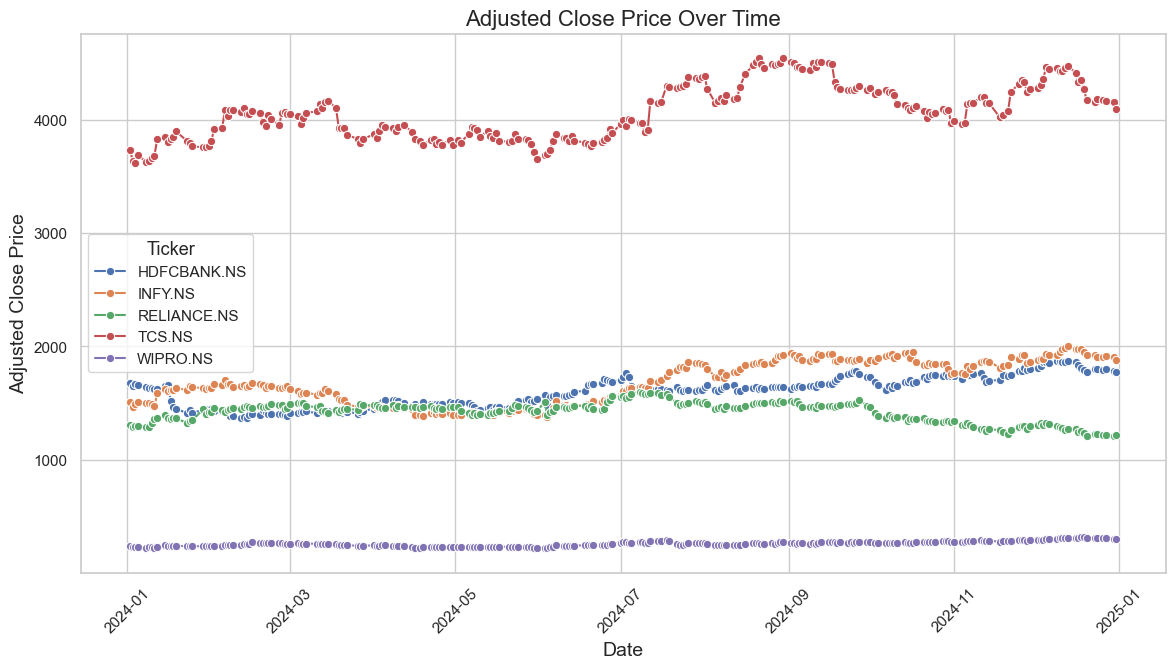

In [4]:
stock_data['Date'] =pd.to_datetime(stock_data['Date'])

stock_data.set_index('Date', inplace=True)
stock_data.reset_index(inplace=True)
plt.figure(figsize=(14, 7))
sns.set(style='whitegrid')

sns.lineplot(data=stock_data, x='Date', y='Close', hue='Ticker', marker='o')

plt.title('Adjusted Close Price Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Adjusted Close Price', fontsize=14)
plt.legend(title='Ticker', title_fontsize='13', fontsize='11')
plt.grid(True)

plt.xticks(rotation=45)
plt.show()

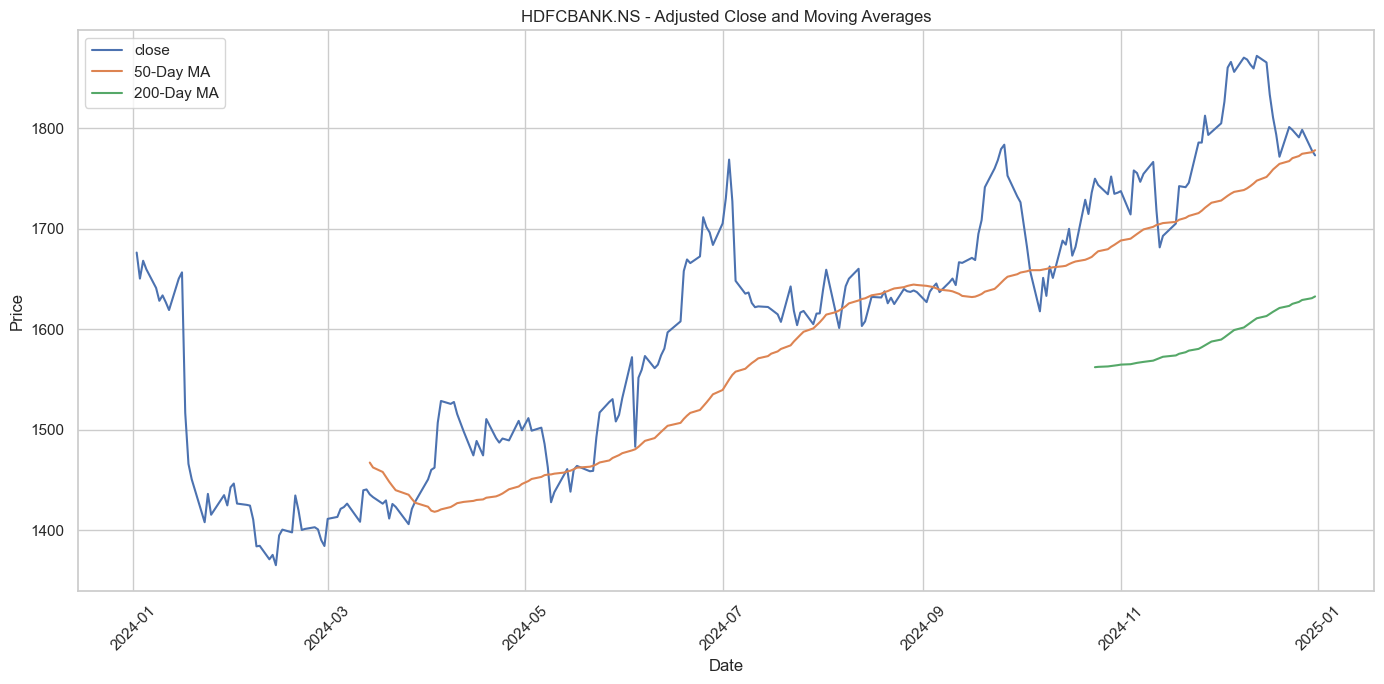

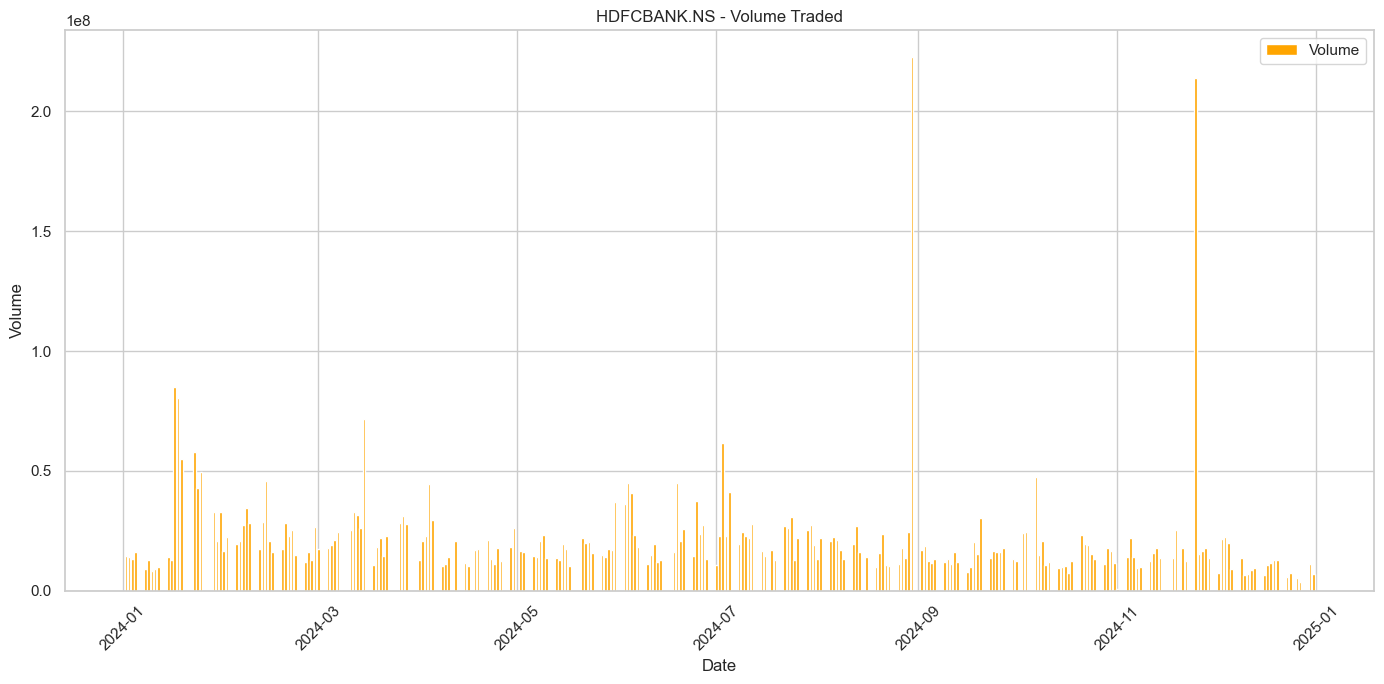

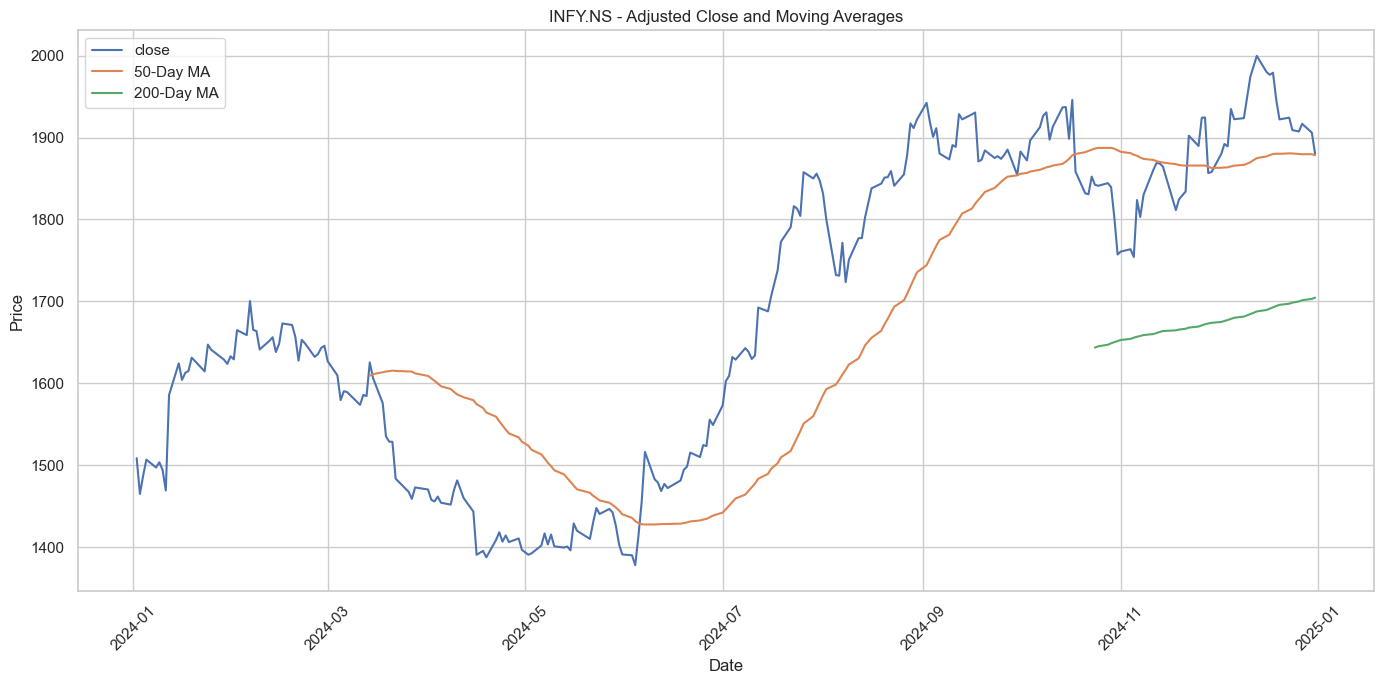

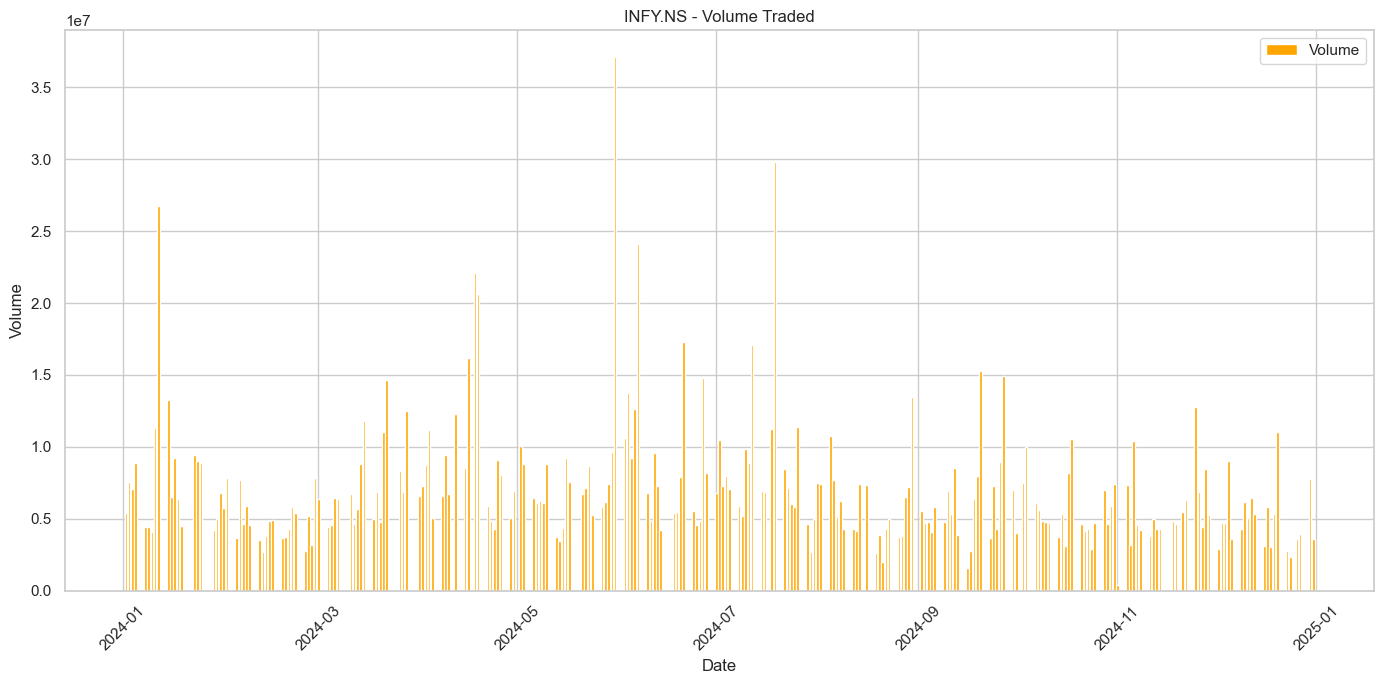

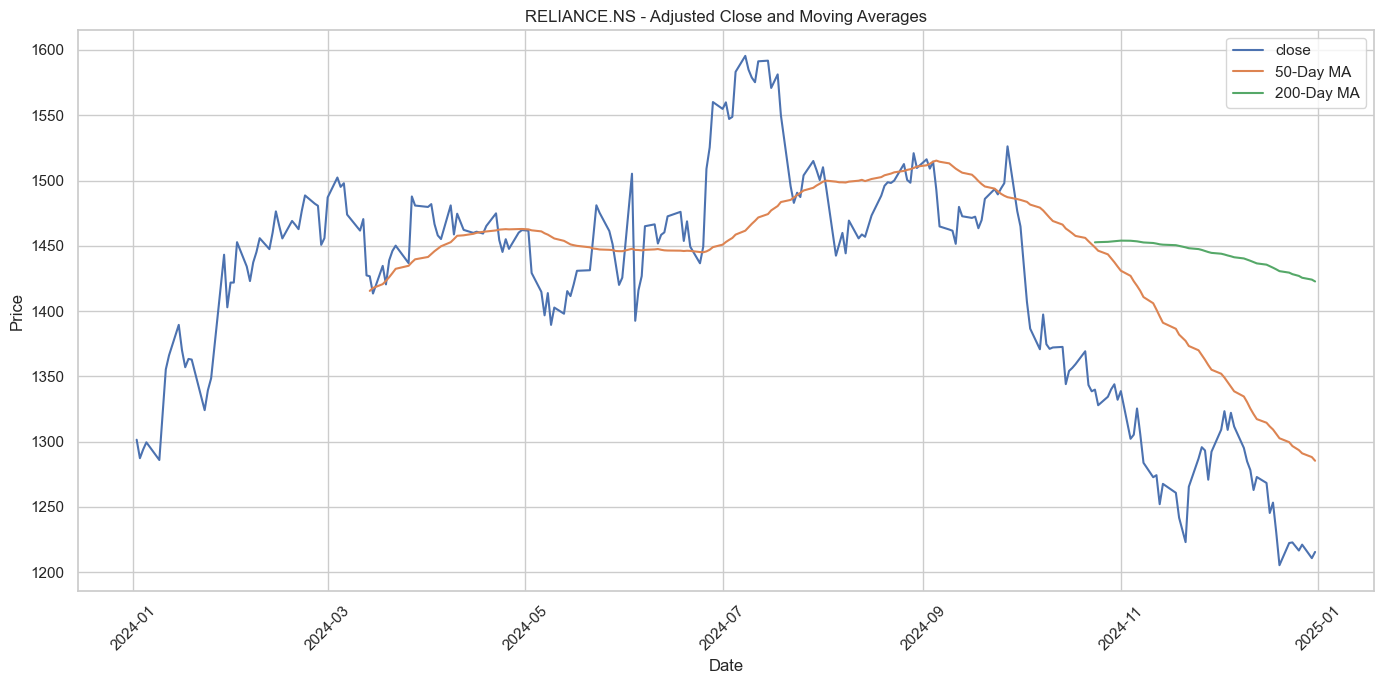

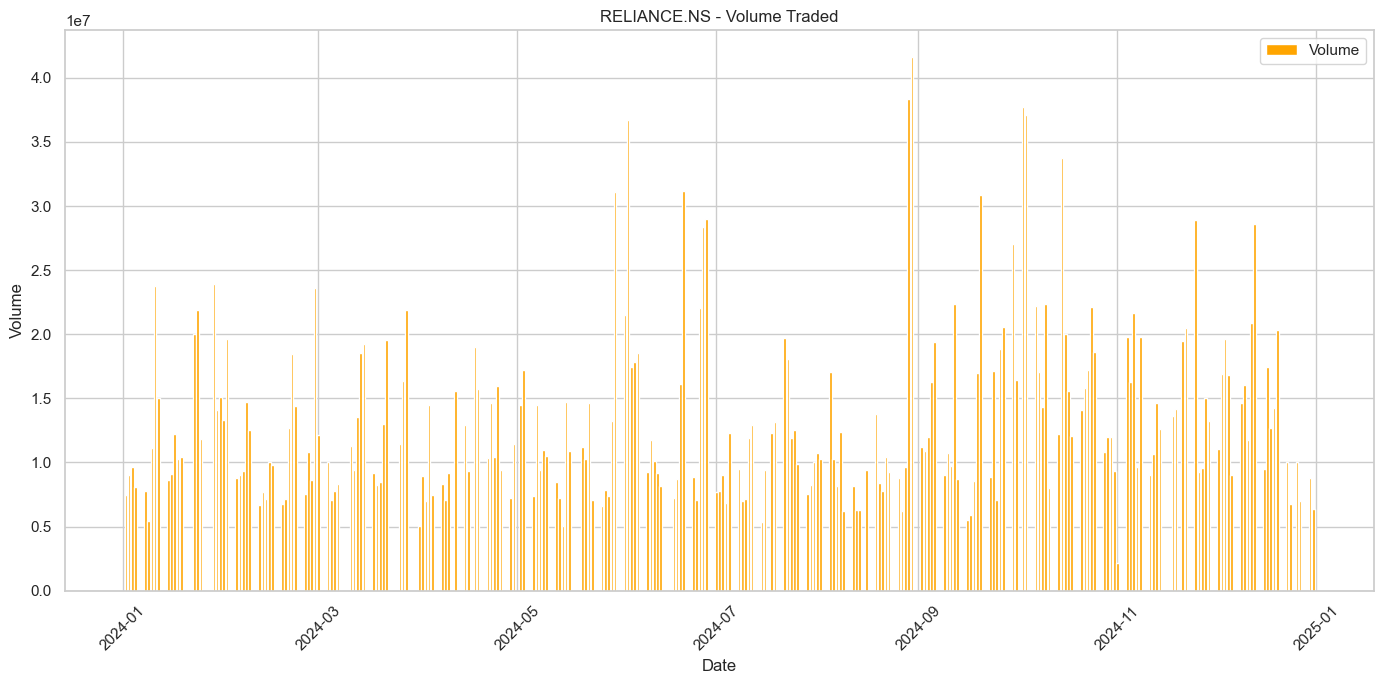

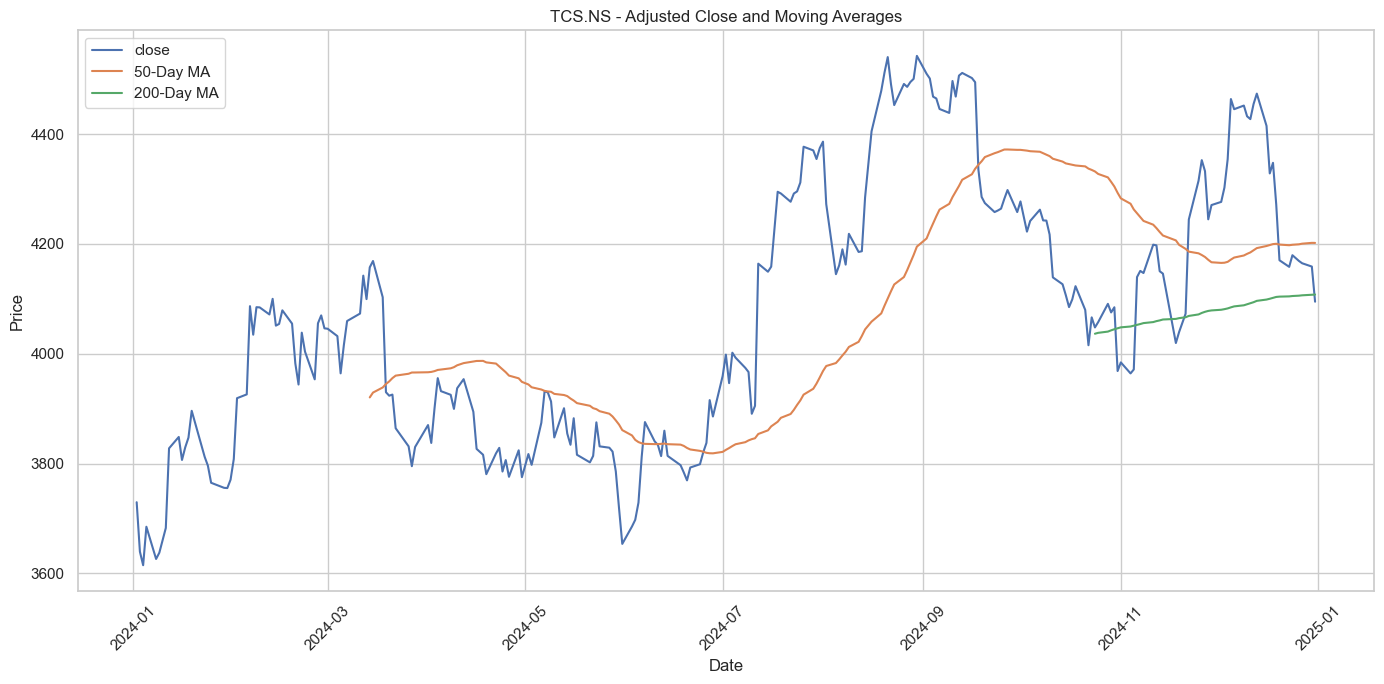

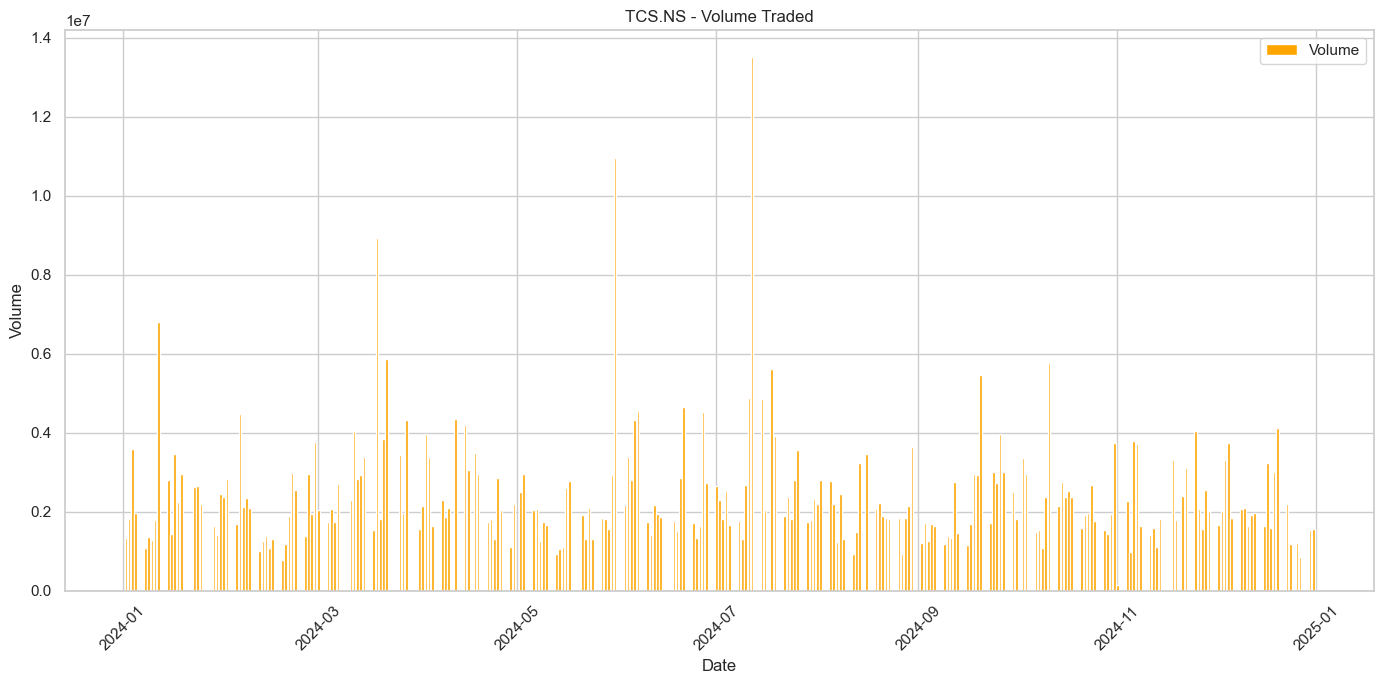

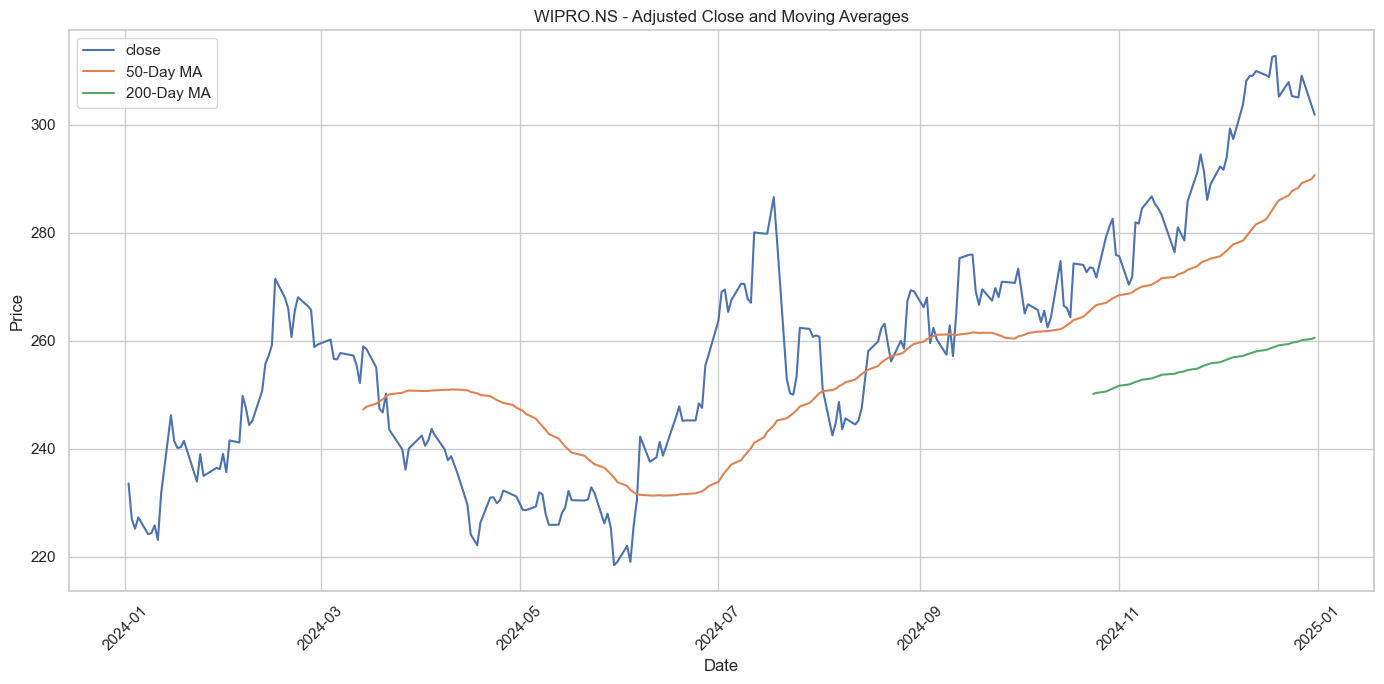

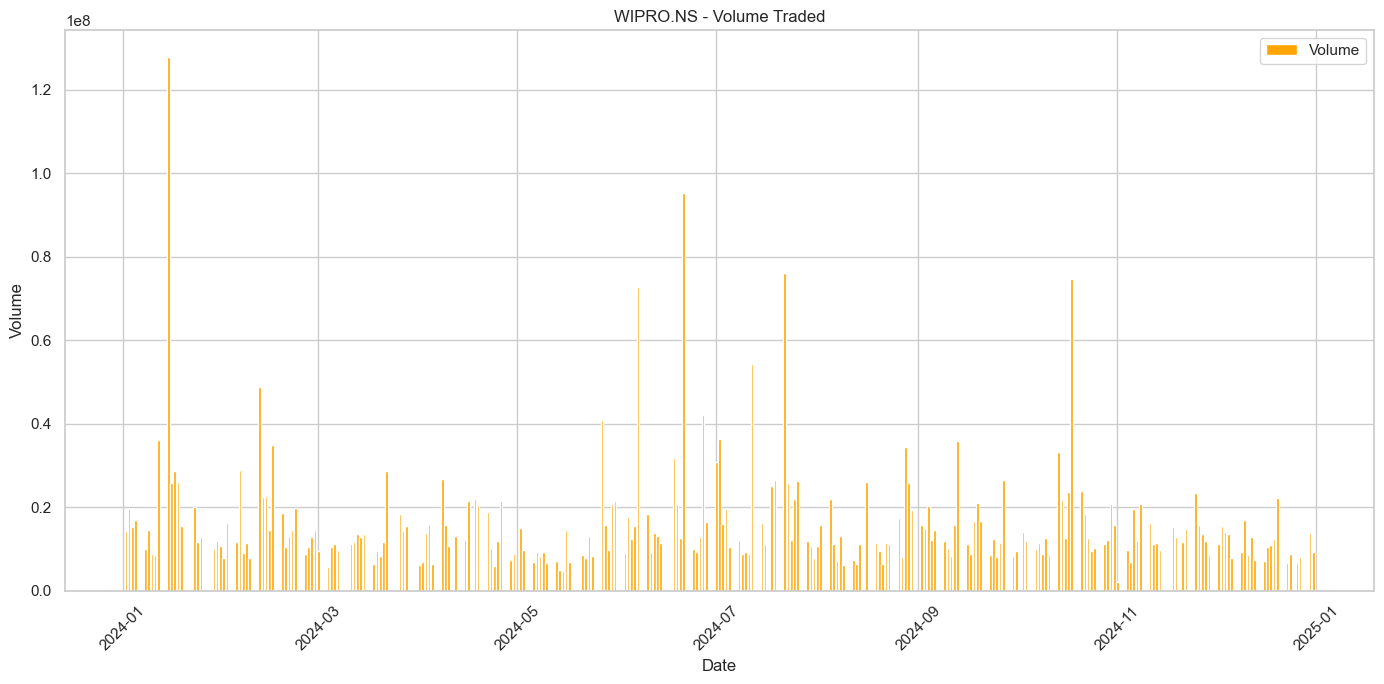

In [5]:
short_window = 50
long_window = 200

if 'Date' not in stock_data.columns:
    print("Error: 'Date' column is missing.")
else:
    stock_data['Date'] = pd.to_datetime(stock_data['Date'], errors='coerce')
    stock_data.dropna(subset=['Date'], inplace=True)
    stock_data.set_index('Date', inplace=True)
unique_tickers = stock_data['Ticker'].unique()

for ticker in unique_tickers:
    ticker_data = stock_data[stock_data['Ticker'] == ticker].copy()
    ticker_data['50_MA'] = ticker_data['Close'].rolling(window=short_window).mean()
    ticker_data['200_MA'] = ticker_data['Close'].rolling(window=long_window).mean()
    
    plt.figure(figsize=(14, 7))
    plt.plot(ticker_data.index, ticker_data['Close'], label='close')
    plt.plot(ticker_data.index, ticker_data['50_MA'], label='50-Day MA')
    plt.plot(ticker_data.index, ticker_data['200_MA'], label='200-Day MA')
    plt.title(f'{ticker} - Adjusted Close and Moving Averages')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(14, 7))
    plt.bar(ticker_data.index, ticker_data['Volume'], label='Volume', color='orange')
    plt.title(f'{ticker} - Volume Traded')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()    

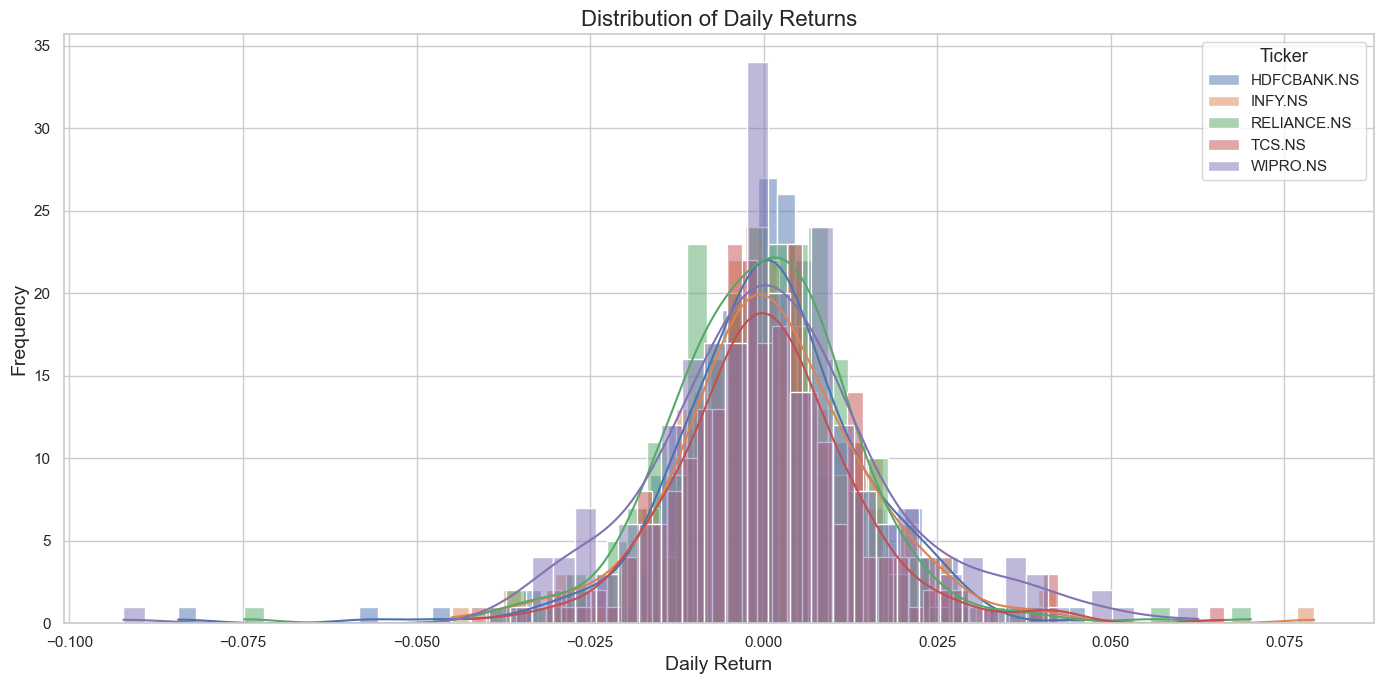

In [6]:
stock_data['Daily Return'] = stock_data.groupby('Ticker')['Close'].pct_change()

plt.figure(figsize=(14, 7))
sns.set(style='whitegrid')

for ticker in unique_tickers:
    ticker_data = stock_data[stock_data['Ticker'] == ticker]
    sns.histplot(ticker_data['Daily Return'].dropna(), bins=50, kde=True, label=ticker, alpha=0.5)

plt.title('Distribution of Daily Returns', fontsize=16)
plt.xlabel('Daily Return', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(title='Ticker', title_fontsize='13', fontsize='11')
plt.grid(True)
plt.tight_layout()
plt.show()

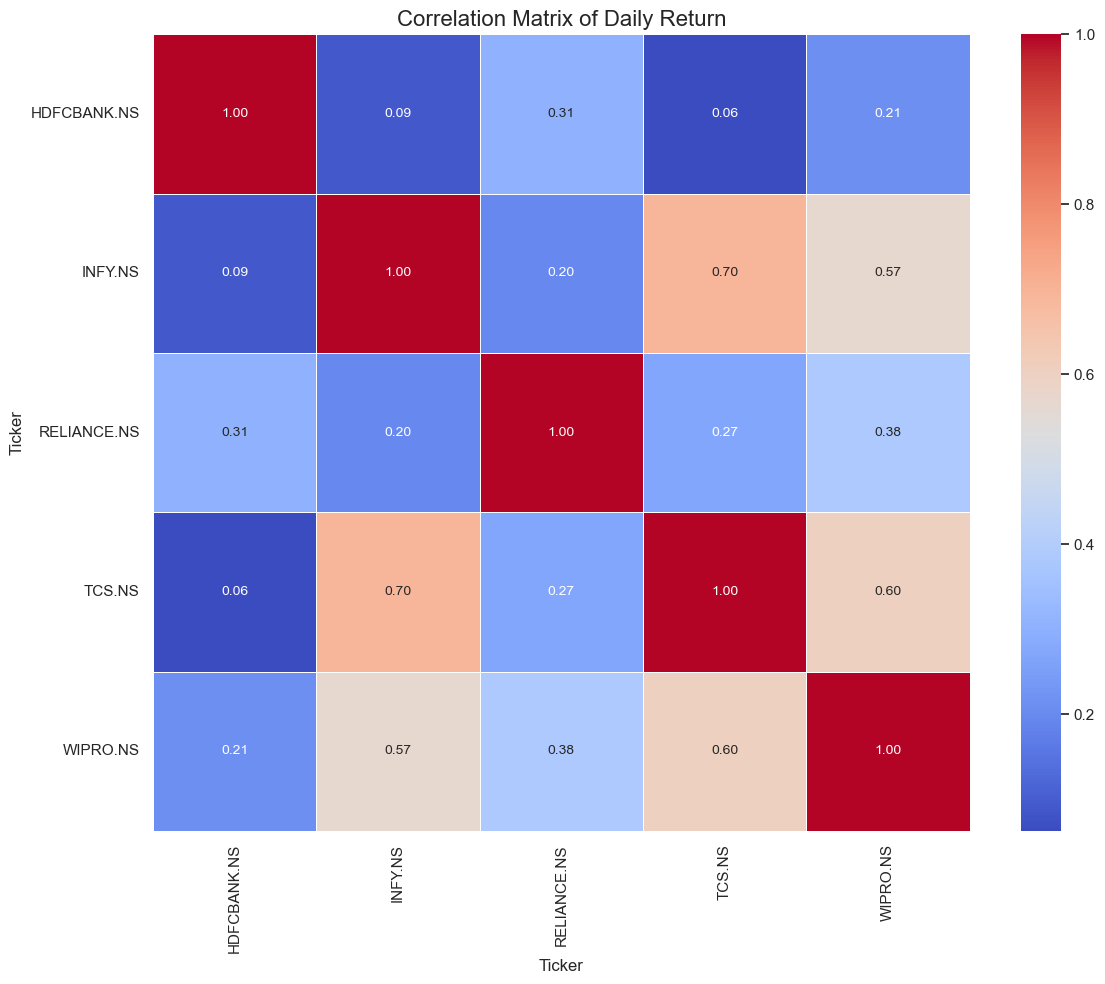

In [7]:
daily_returns = stock_data.pivot_table(index='Date', columns='Ticker', values='Daily Return')
correlation_matrix = daily_returns.corr()

plt.figure(figsize=(12, 10))
sns.set(style='whitegrid')

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5, fmt='.2f', annot_kws={'size': 10})
plt.title('Correlation Matrix of Daily Return', fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [8]:
expected_returns = daily_returns.mean() * 252 # annualize the returns
volatility = daily_returns.std() * np.sqrt(252) # annualize the volatility

stock_stats = pd.DataFrame({
    'Expected Return': expected_returns,
    'Volatility': volatility
})
stock_stats

,Expected Return,Volatility
Ticker,,
HDFCBANK.NS,0.083269,0.224516
INFY.NS,0.253470,0.229482
RELIANCE.NS,-0.044288,0.229777
TCS.NS,0.118748,0.211838
WIPRO.NS,0.303927,0.279959


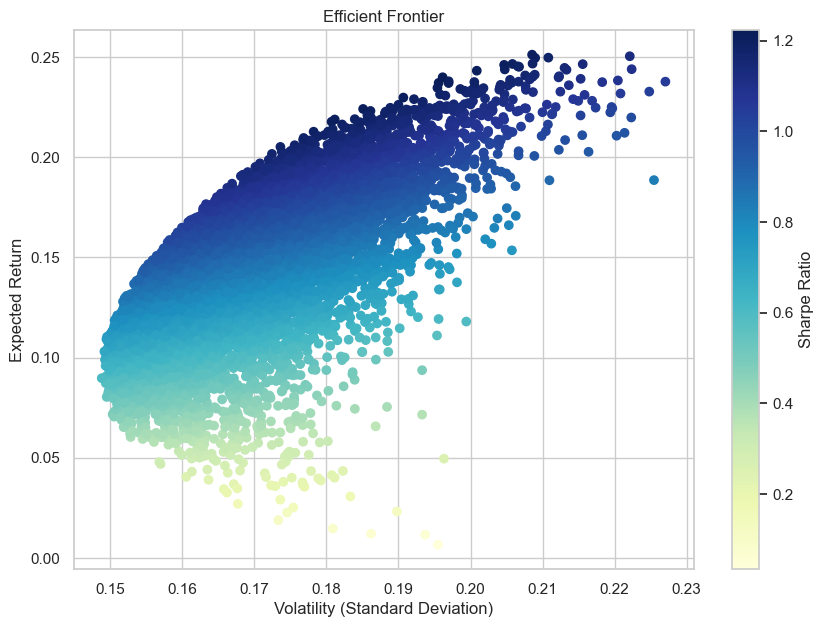

In [9]:
# function to calculate portfolio performance
def portfolio_performance(weights, returns, cov_matrix):
    portfolio_return = np.dot(weights, returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_volatility

# number of portfolios to simulate
num_portfolios = 10000

# array to store the results
results = np.zeros((3, num_portfolios))

# annualized covariance matrix
cov_matrix = daily_returns.cov() * 252

np.random.seed(42)

for i in range(num_portfolios):
    weights = np.random.random(len(unique_tickers))
    weights /= np.sum(weights)
    
    portfolio_return, portfolio_volatility = portfolio_performance(weights, expected_returns, cov_matrix)
    
    results[0,i] = portfolio_return
    results[1,i] = portfolio_volatility
    results[2,i] = portfolio_return / portfolio_volatility # sharpe Ratio

plt.figure(figsize=(10, 7))
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='YlGnBu', marker='o')
plt.title('Efficient Frontier')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')
plt.grid(True)
plt.show()

In [10]:
max_sharpe_idx = np.argmax(results[2])
max_sharpe_return = results[0, max_sharpe_idx]
max_sharpe_volatility = results[1, max_sharpe_idx]
max_sharpe_ratio = results[2, max_sharpe_idx]

max_sharpe_return, max_sharpe_volatility, max_sharpe_ratio

(0.23988100350054944, 0.1961279998559888, 1.2230839231353363)

In [11]:
max_sharpe_weights = np.zeros(len(unique_tickers))

for i in range(num_portfolios):
    weights = np.random.random(len(unique_tickers))
    weights /= np.sum(weights)
    
    portfolio_return, portfolio_volatility = portfolio_performance(weights, expected_returns, cov_matrix)
    
    if results[2, i] == max_sharpe_ratio:
        max_sharpe_weights = weights
        break

portfolio_weights_df = pd.DataFrame({
    'Ticker': unique_tickers,
    'Weight': max_sharpe_weights
})
portfolio_weights_df

,Ticker,Weight
0,HDFCBANK.NS,0.306711
1,INFY.NS,0.185024
2,RELIANCE.NS,0.034908
3,TCS.NS,0.144246
4,WIPRO.NS,0.329112
